<a href="https://colab.research.google.com/github/chenweioh/toolkits/blob/main/Fraud_Detection_in_BE_Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#User Guide: Bioequivalence Trial Analysis Tool

###Overview
Welcome to the Bioequivalence Trial Analysis Tool! This user-friendly tool is designed to help detect potential fraudulent activities in bioequivalence trials. Inspired by Anders Fuglsang's research, the tool is implemented based on his third plot method. This guide will walk you through how to use the tool effectively.

###Table of Contents
*   Requirements
*   Getting Started
*   Excel Format
*   Uploading Data
*   Security Warning
*   Running the Analysis
*   Interpreting Results
*   Original Data and Verification
*   Troubleshooting
*   Reference to Original Article
*   Feedback and Contributions

###Requirements
An internet connection to access Google Colab

Data for analysis in Excel (.xlsx) format

###Getting Started
To get started, open this notebook in Google Colab if you haven't already.

###Excel Format
Your Excel data should adhere to the following format and column name for optimal results:

*   Column A: Subj
*   Column B: Seq
*   Column C: Per
*   Column D: Trt
*   Column E: Var

###Uploading Data
*   Click the "Play" button next to each code cell to run them one at a time.
*   Alternatively, go to the "Runtime" tab in the menu and select "Run All" to

####Security Warning
When you open this notebook in Google Colab, you may see the following warning:

> "This notebook was not authored by Google. This notebook is being loaded from GitHub. It may request access to your data stored with Google, or read data and credentials from other sessions. Please review the source code before executing this notebook."

This is a standard security warning. Feel free to review the source code in this notebook before proceeding. We take your data privacy seriously and have not included any code that would compromise your personal information.

If you've reviewed the code and feel comfortable with it, you can proceed by clicking 'Run Anyway'.

*   Next, you will see the upload dialog appear below the code cell.

*   Choose your Excel (.xlsx) file and upload it.

###Running the Analysis
Wait for the analysis to complete; this might take a few minutes depending on the size of your data.
###Interpreting Results
Upon successful analysis, the tool will generate plots and tables to help you understand the bioequivalence metrics.

###Original Data and Verification
For your verification purposes, I have provided a sample of original data which can be accessed at this [link](https://docs.google.com/spreadsheets/d/1JgJ0ooZRjjOD2D9H0cIp3Uq45zku0C8i/edit?usp=drive_link&ouid=102636526263516889334&rtpof=true&sd=true).


The plot for the original data should look like:
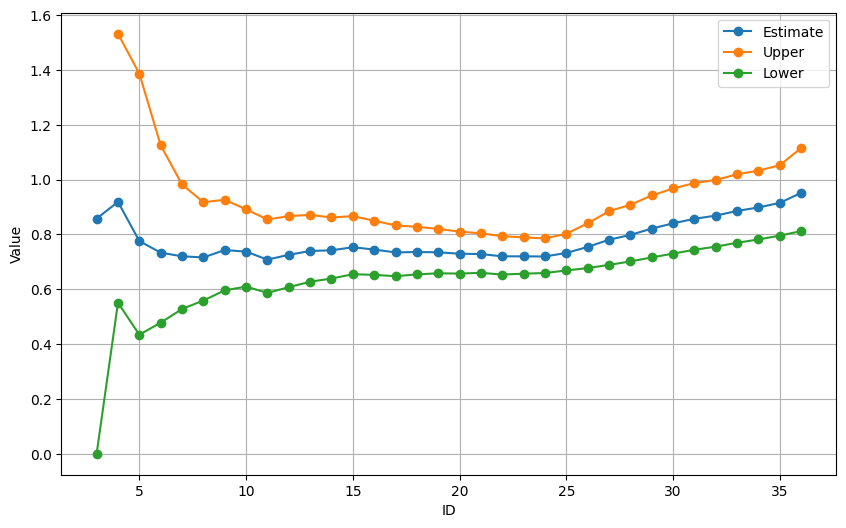

###Troubleshooting
If you encounter errors during data upload, make sure your Excel file is formatted correctly.
If the analysis doesn't run as expected, double-check that you've run all the prerequisite cells in order.

###Reference to Original Article
For a more comprehensive understanding of the methods employed in this tool, you can refer to the original article by Anders Fuglsang. The article provides valuable insights into the methods for detecting fraudulent activities in bioequivalence trials. The original article can be found [here](https://www.sciencedirect.com/science/article/abs/pii/S0928098720303833).

###Feedback and Contributions
If you have suggestions for improvements or find any bugs, please create an issue on the GitHub repository. Contributions are always welcome!

We hope you find this tool useful for your bioequivalence trials analysis. Thank you for using it!

Saving PK Tables for Levodopa3.xlsx to PK Tables for Levodopa3 (9).xlsx
Estimate: 0.9192685156781656, 90% CI: 0.8327934733870082-1.01472289459746


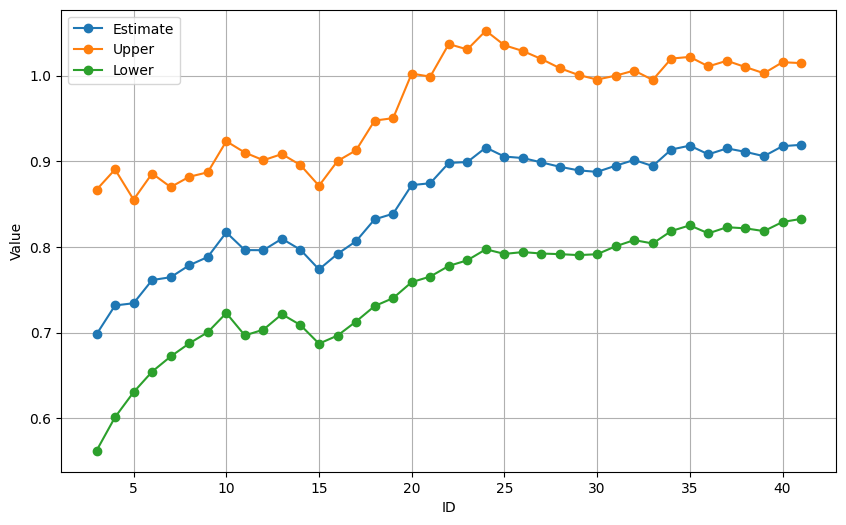

In [15]:
from google.colab import files
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats

import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in double_scalars")


# Upload the Excel file
uploaded = files.upload()

# Get the filename
uploaded_filename = list(uploaded.keys())[0]

# Read the data from the uploaded Excel file
df = pd.read_excel(uploaded_filename)
#print(df)

# Check if the Excel has the required column headers
required_columns = ['Subj', 'Seq', 'Per', 'Trt', 'Var']

if not all(col in df.columns for col in required_columns):
    print("The Excel file must have the following columns: Subj, Seq, Per, Trt, Var.")
else:
    # Placeholder for storing results
    all_data = pd.DataFrame()
    num_rows = df.shape[0]  # Total number of rows in df
    num_subjects = num_rows // 2  # Assuming each subject has exactly 2 rows

    for n in range(6, num_subjects + 1):  # Automatically set the range based on the number of subjects
    # Your existing code here

        # Subset data based on subject
        sub_df = df[df['Subj'] < n].copy()

        # Apply log transformation
        sub_df['LVar'] = np.log(sub_df['Var'])

        # Fit the generalized linear model
        model = smf.glm("LVar ~ C(Seq) +C(Subj): C(Seq) + C(Per) + C(Trt)", data=sub_df, family=sm.families.Gaussian()).fit()

        # Retrieve the estimate for 'T vs R'
        estimate = model.params['C(Trt)[T.T]']
        # Print the estimate


        # Calculate ratio, upper, and lower
        ratio = np.exp(estimate)

        dfree = model.df_resid
        ct = -1 * stats.t.ppf(0.05 / 2, dfree)
        stderr = model.bse['C(Trt)[T.T]']
        lower = np.exp(estimate - (ct * stderr))
        upper = np.exp(estimate + (ct * stderr))

        # Store results
        #all_data = all_data.append({'ratio': ratio, 'upper': upper, 'lower': lower}, ignore_index=True)
        new_row = pd.DataFrame({'ratio': [ratio], 'upper': [upper], 'lower': [lower]})
        all_data = pd.concat([all_data, new_row], ignore_index=True)

    #Print ratio, upper, lower
    #print(model.summary())
    print(f"Estimate: {ratio}, 90% CI: {lower}-{upper}")

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(all_data.index + 3, all_data['ratio'], label='Estimate',marker='o')  # adding 3 because the loop starts from 3
    plt.plot(all_data.index + 3, all_data['upper'], label='Upper',marker='o')
    plt.plot(all_data.index + 3, all_data['lower'], label='Lower',marker='o')
    plt.xlabel('ID')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
